In [12]:
import torch
import copy
from torchvision import models
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import optim
from torch import nn
from torch.nn import functional as F
 
import argparse
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
def load_dataset(num):
    green_dir = f'C:\\Users\\WorkStation\\Desktop\\캡디이미지\\CAE_dataset\\client{num}\\green'
    yellow_dir = f'C:\\Users\\WorkStation\\Desktop\\캡디이미지\\CAE_dataset\\client{num}\\yellow'
    red_dir = f'C:\\Users\\WorkStation\\Desktop\\캡디이미지\\CAE_dataset\\client{num}\\red'
    blue_dir = f'C:\\Users\\WorkStation\\Desktop\\캡디이미지\\CAE_dataset\\client{num}\\blue'

    green_set = datasets.ImageFolder(
        green_dir,
        transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
    )

    yellow_set = datasets.ImageFolder(
        yellow_dir,
        transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
    )

    red_set = datasets.ImageFolder(
        red_dir,
        transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
    )

    blue_set = datasets.ImageFolder(
        blue_dir,
        transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
    )

    green_train, green_test = torch.utils.data.random_split(green_set, [250, 50])  
    yellow_train, yellow_test = torch.utils.data.random_split(yellow_set, [250, 50])  
    red_train, red_test = torch.utils.data.random_split(red_set, [250, 50]) 
    blue_train, blue_test = torch.utils.data.random_split(blue_set, [250, 50]) 


    normal_set = green_set + blue_set
    abnormal_set = red_set + yellow_set

    if num==1:
        train_set = list(green_train)[:int(len(green_train)*0.2)] + list(blue_train)[:int(len(blue_train)*0.8)]
        test_set = green_test + blue_test
    else:
        train_set = list(green_train)[:int(len(green_train)*0.8)] + list(blue_train)[:int(len(blue_train)*0.2)]
        test_set = green_test + blue_test
    

    return normal_set, abnormal_set, train_set, test_set


normal_set1, abnormal_set1, train_set1, test_set1 = load_dataset(1)
normal_set2, abnormal_set2, train_set2, test_set2 = load_dataset(2)

normal_set = normal_set1 + normal_set2
abnormal_set = abnormal_set1 + abnormal_set2
test_set = test_set1 + test_set2

In [14]:
def plot_loss(round_loss, round_client_losses):
    from mpl_toolkits.axes_grid1.inset_locator import mark_inset, inset_axes
    ax = plt.subplot(1,1,1)
    ax.plot(round_loss, label='Avg')
    ax.set_xlabel('$Round$')
    ax.set_ylabel('$Loss$')
    ax.plot(np.array(round_client_losses)[:,0], label='Client1')
    ax.plot(np.array(round_client_losses)[:,1], label='Client2')
    ax.grid()
    ax.legend()

    axins = inset_axes(ax, 1.0, 0.8, loc = 1, bbox_to_anchor=(0.6, 0.75), bbox_transform = ax.figure.transFigure)
    
    axins.plot(round_loss, label = 'Avg')
    axins.plot(np.array(round_client_losses)[:,0], label = 'Client1')
    axins.plot(np.array(round_client_losses)[:,1], label = 'Client2')
    axins.set_xlim(-0.5, 5)
    axins.set_ylim(0.05,0.07)
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec = "0.4")

    plt.show()

In [15]:
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvAutoEncoder, self).__init__()
        
        # Encoder
        self.cnn_layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2))
        
        self.cnn_layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2))

        # Decoder        
        self.tran_cnn_layer1 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size = 2, stride = 2, padding=0),
            nn.ReLU())

        self.tran_cnn_layer2 = nn.Sequential(
            nn.ConvTranspose2d(32, 3, kernel_size = 2, stride = 2, padding=0),
            nn.Sigmoid())
            
            
    def forward(self, x):
        output = self.cnn_layer1(x)
        output = self.cnn_layer2(output)      
        output = self.tran_cnn_layer1(output)
        output = self.tran_cnn_layer2(output)
        
        return output

In [16]:
def load_data(): 
    ldt_loss = pd.read_csv(f"Loss/loss.csv")
    ldt_client_losses = pd.read_csv(f"Loss/client_losses.csv")

    ldt_loss, ldt_client_losses = np.delete(ldt_loss.values, 0, 1), np.delete(ldt_client_losses.values, 0, 1)
    return ldt_loss, ldt_client_losses

In [17]:
round_loss, round_client_losses = load_data()
print(round_loss.shape, round_client_losses.shape)

(1000, 1) (1000, 2)


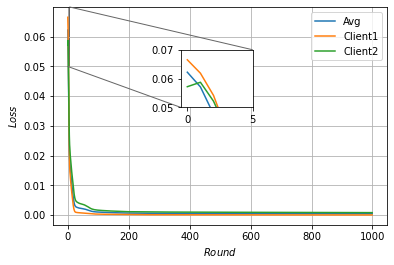

In [18]:
plot_loss(round_loss, round_client_losses)

In [19]:
seed = 1228
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")

args.num_epochs = 5
args.num_rounds = 300
args.num_clients = 2
args.lr = 0.00001

args.batch_size = 8

args.NET_PATH = ''
args.INIT_PATH = f'FL_model/client = {args.num_clients}/initialize_weight.pth'

## **Round=300**

Normal loss: 0.0004938768285501282
Abnormal loss: 0.0018813610503760477


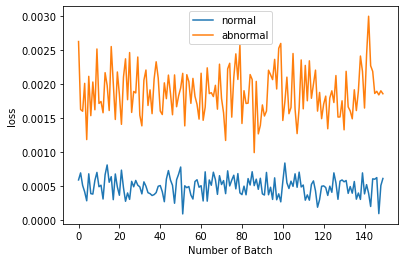

In [20]:
model = ConvAutoEncoder()
model = torch.load(args.INIT_PATH)
model.eval()

criterion = nn.MSELoss()

normal_loss = 0
normal_losses = []

abnormal_loss = 0
abnormal_losses = []

normal_loader = torch.utils.data.DataLoader(normal_set, batch_size=args.batch_size, shuffle=True)
abnormal_loader = torch.utils.data.DataLoader(abnormal_set, batch_size=args.batch_size, shuffle=True)

for i, (normal_img, _) in enumerate(normal_loader):
    normal_img = normal_img.to(device)
    
    normal_outputs = model(normal_img)
    loss = criterion(normal_outputs, normal_img)
    normal_loss += loss.item()
    normal_losses.append(loss.item())
    
print(f'Normal loss: {normal_loss/len(normal_loader)}')
    
for i, (abnormal_img, _) in enumerate(abnormal_loader):   
    abnormal_img = abnormal_img.to(device)
    
    abnormal_outputs = model(abnormal_img)
    loss = criterion(abnormal_outputs, abnormal_img)
    abnormal_loss += loss.item()
    abnormal_losses.append(loss.item())
    
print(f'Abnormal loss: {abnormal_loss/len(abnormal_loader)}')


plt.plot(normal_losses, label = 'normal')
plt.plot(abnormal_losses[:len(normal_loader)], label = 'abnormal')
plt.xlabel('Number of Batch')
plt.ylabel('loss')
plt.legend()
plt.show()

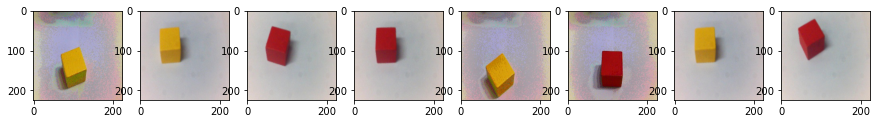

0.0022469128016382456
0.0008886258001439273
0.0011107393074780703
0.0011780785862356424
0.0020456667989492416
0.0033717742189764977
0.0009004452149383724
0.0011404280085116625


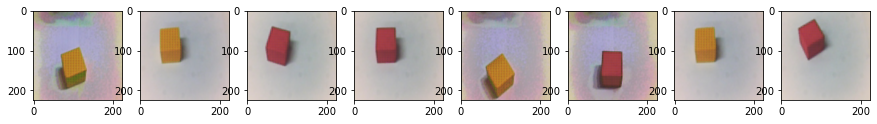

In [21]:
abnormal_images, abnormal_labels = next(iter(abnormal_loader))

fig = plt.figure(figsize=(15,3))

for i, img, label in zip(range(8), abnormal_images, abnormal_labels):
    numpy_img = np.transpose(img.detach().numpy(), (1, 2, 0))
    ax = fig.add_subplot(1, 8, i+1)
    ax.imshow(numpy_img)
plt.show()



model.cpu()
abnormal_output = model(abnormal_images)

fig = plt.figure(figsize=(15,3))
for i, img, label in zip(range(8), abnormal_output, abnormal_labels):
    loss = criterion(img, abnormal_images[i])
    print(loss.item())
    
    numpy_img = np.transpose(img.detach().numpy(), (1, 2, 0))
    ax = fig.add_subplot(1, 8, i+1)
    ax.imshow(numpy_img)
plt.show()

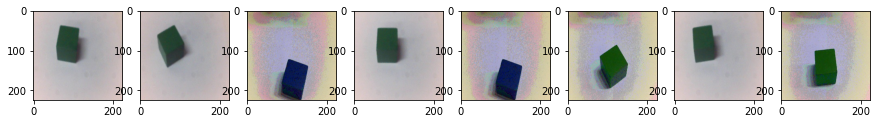

9.516978752799332e-05
8.784805686445907e-05
0.0010022406931966543
9.89082982414402e-05
0.0010011376580223441
0.0008900227257981896
9.317090007243678e-05
0.0008777943439781666


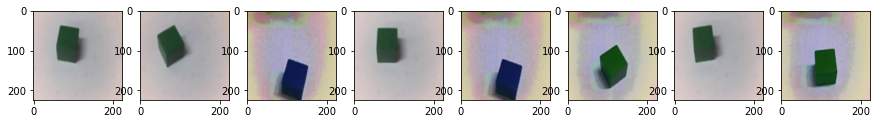

In [22]:
normal_images, normal_labels = next(iter(normal_loader))

fig = plt.figure(figsize=(15,3))

for i, img, label in zip(range(8), normal_images, normal_labels):
    numpy_img = np.transpose(img.detach().numpy(), (1, 2, 0))
    ax = fig.add_subplot(1, 8, i+1)
    ax.imshow(numpy_img)
plt.show()


model.cpu()
normal_output = model(normal_images)

fig = plt.figure(figsize=(15,3))
for i, img, label in zip(range(8), normal_output, normal_labels):
    loss = criterion(img, normal_images[i])
    print(loss.item())
    
    numpy_img = np.transpose(img.detach().numpy(), (1, 2, 0))
    ax = fig.add_subplot(1, 8, i+1)
    ax.imshow(numpy_img)
plt.show()

## **Round=5**

Normal loss: 0.021672721666594345
Abnormal loss: 0.019757756032049656


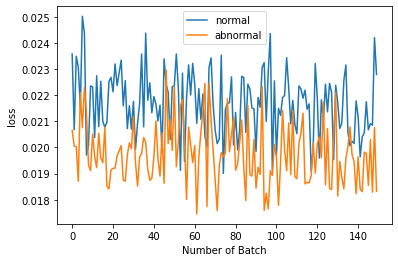

In [23]:
model = ConvAutoEncoder()
model = torch.load('model_per_round/round_5_weight.pth')
model.eval()

criterion = nn.MSELoss()

normal_loss = 0
normal_losses = []

abnormal_loss = 0
abnormal_losses = []

normal_loader = torch.utils.data.DataLoader(normal_set, batch_size=args.batch_size, shuffle=True)
abnormal_loader = torch.utils.data.DataLoader(abnormal_set, batch_size=args.batch_size, shuffle=True)

for i, (normal_img, _) in enumerate(normal_loader):
    normal_img = normal_img.to(device)
    
    normal_outputs = model(normal_img)
    loss = criterion(normal_outputs, normal_img)
    normal_loss += loss.item()
    normal_losses.append(loss.item())
    
print(f'Normal loss: {normal_loss/len(normal_loader)}')
    
for i, (abnormal_img, _) in enumerate(abnormal_loader):   
    abnormal_img = abnormal_img.to(device)
    
    abnormal_outputs = model(abnormal_img)
    loss = criterion(abnormal_outputs, abnormal_img)
    abnormal_loss += loss.item()
    abnormal_losses.append(loss.item())
    
print(f'Abnormal loss: {abnormal_loss/len(abnormal_loader)}')


plt.plot(normal_losses, label = 'normal')
plt.plot(abnormal_losses[:len(normal_loader)], label = 'abnormal')
plt.xlabel('Number of Batch')
plt.ylabel('loss')
plt.legend()
plt.show()

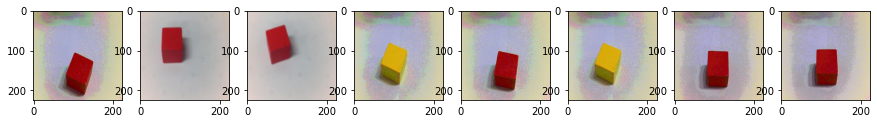

0.026702649891376495
0.017975881695747375
0.018909011036157608
0.020853959023952484
0.026492485776543617
0.02078268863260746
0.024172300472855568
0.024757321923971176


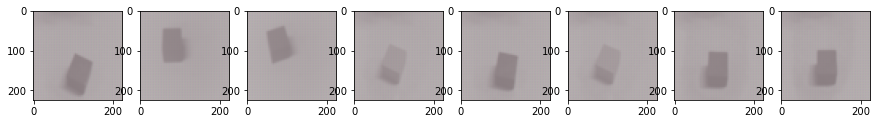

In [24]:
abnormal_images, abnormal_labels = next(iter(abnormal_loader))

fig = plt.figure(figsize=(15,3))

for i, img, label in zip(range(8), abnormal_images, abnormal_labels):
    numpy_img = np.transpose(img.detach().numpy(), (1, 2, 0))
    ax = fig.add_subplot(1, 8, i+1)
    ax.imshow(numpy_img)
plt.show()



model.cpu()
abnormal_output = model(abnormal_images)

fig = plt.figure(figsize=(15,3))
for i, img, label in zip(range(8), abnormal_output, abnormal_labels):
    loss = criterion(img, abnormal_images[i])
    print(loss.item())
    
    numpy_img = np.transpose(img.detach().numpy(), (1, 2, 0))
    ax = fig.add_subplot(1, 8, i+1)
    ax.imshow(numpy_img)
plt.show()

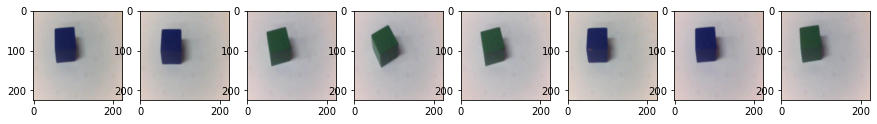

c:\Users\WorkStation\anaconda3\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([8, 3, 224, 224])) that is different to the input size (torch.Size([3, 224, 224])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0.05167944356799126
0.05158238857984543
0.05138318985700607
0.05141068249940872
0.05113981291651726
0.05137329921126366
0.05138052999973297
0.051636092364788055


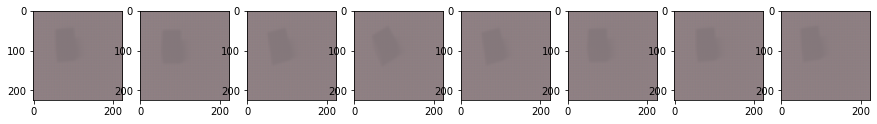

In [ ]:
normal_images, normal_labels = next(iter(normal_loader))

fig = plt.figure(figsize=(15,3))

for i, img, label in zip(range(8), normal_images, normal_labels):
    numpy_img = np.transpose(img.detach().numpy(), (1, 2, 0))
    ax = fig.add_subplot(1, 8, i+1)
    ax.imshow(numpy_img)
plt.show()


model.cpu()
normal_output = model(normal_images)

fig = plt.figure(figsize=(15,3))
for i, img, label in zip(range(8), normal_output, normal_labels):
    loss = criterion(img, normal_images)
    print(loss.item())
    
    numpy_img = np.transpose(img.detach().numpy(), (1, 2, 0))
    ax = fig.add_subplot(1, 8, i+1)
    ax.imshow(numpy_img)
plt.show()